In [1]:
import gzip
import os
import shutil
import time
import matplotlib.pyplot as plt
import numpy as np
import psutil
import wget
from prody import *

In [2]:
os.chdir('../data/capsid_pdbs')
pdb = '1a34'
filename = pdb + '_full.pdb'
if not os.path.exists(filename):
    vdb_url = 'https://files.rcsb.org/download/' + pdb + '.pdb.gz'
    print(vdb_url)
    vdb_filename = wget.download(vdb_url)
    with gzip.open(vdb_filename, 'rb') as f_in:
        with open(filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
capsid, header = parsePDB(filename, biomol=True, header=True)
os.chdir('../../src')

@> 3428 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Biomolecular transformations were applied to the coordinate data.


In [3]:
calphas = capsid.select('ca').copy()
coords = calphas.getCoords()
n = coords.shape[0]
print(n)
cutoff = 10

8820


In [4]:
import numpy as np

def build(calphas, header):
    from scipy.sparse import bsr_matrix
    coords = calphas.getCoords()
    n_atoms = coords.shape[0]
    T = extract_transforms(header)
    gT = buildGroupTable(T)
    gL = buildGroupLookup(gT)
    gS = buildGroupShift(gL)
    print('building base')
    start = time.time()
    hbrow, hbcol, hbdata = hessBaseS(coords, T)
    print(hbcol.shape)
    end = time.time()
    print('done', end-start)
    print('building full')
    start = time.time()
    hRow, hCol, hData = buildHessFull(hbrow,hbcol,hbdata, T, gS, n_atoms)
    hFull = bsr_matrix((hData,hCol, hRow), blocksize=(3,3), shape=(3*n_atoms,3*n_atoms))
    end = time.time()
    print('done', end-start)
    return hFull

def extract_transforms(header):
    biomt = header.get('biomoltrans')
    if not isinstance(biomt, dict) or len(biomt) == 0:
        LOGGER.warn("no biomolecular transformations found so original structure was used")
        return atoms

    biomols = []
    keys = list(biomt)

    keys.sort()
    for i in keys:
        segnm = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ' * 20)
        ags = []
        mt = biomt[i]
        # mt is a list, first item is list of chain identifiers
        # following items are lines corresponding to transformation
        # mt must have 3n + 1 lines
        if (len(mt)) % 4 != 0:
            LOGGER.warn('Biomolecular transformations {0} were not '
                        'applied'.format(i))
            continue

        T = []
        for times in range(int((len(mt)) / 4)):
            rotation = np.zeros((3, 3), dtype=np.float64)
            translation = np.zeros(3)
            line0 = np.fromstring(mt[times * 4 + 1], sep=' ')
            rotation[0, :] = line0[:3]
            translation[0] = line0[3]
            line1 = np.fromstring(mt[times * 4 + 2], sep=' ')
            rotation[1, :] = line1[:3]
            translation[1] = line1[3]
            line2 = np.fromstring(mt[times * 4 + 3], sep=' ')
            rotation[2, :] = line2[:3]
            translation[2] = line2[3]
            T.append(rotation)

        return np.array(T)

def buildGroupTable(T):
    gTable = np.zeros((60, 60), dtype=int)
    for i in range(60):
        for j in range(60):
            arr1 = T[i]
            arr2 = T[j]
            r = arr1 @ arr2
            for k in range(60):
                if np.allclose(r, T[k]):
                    gTable[i, j] = k
                else:
                    continue
    return gTable

def groupFind(k,l, gT):
    row = gT[k, :]
    return int(np.nonzero(row==l)[0][0])

def buildGroupLookup(gT):
    groupLookup = np.empty((60, 60), dtype=int)
    for i in range(60):
        for j in range(60):
            groupLookup[i, j] = groupFind(i, j, gT)
    return groupLookup

def buildGroupShift(gL):
    gS = np.zeros_like(gL)
    for i in range(60):
        for j in range(60):
            gS[i, j] = gL[0,j] - gL[i, j]
    return gS

def buildGroupShiftLookup(gL):
    gSL = np.zeros_like(gL)
    for i in range(60):
        for j in range(60):
            l1 = gL[0,:]
            l2 = np.nonzero(gL[i,:]==j)
            gSL[i, j] = int(np.nonzero(gL[0,:]==j)[0][0]) - int(np.nonzero(gL[i,:]==j)[0][0])
    return gSL


def hessBaseS(coords, transforms):
    n = coords.shape[0]
    n_asym = int(n / 60)
    hRow = []
    hCol = []
    hData = []
    diagInds = []
    hDiags = np.zeros((n_asym, 3, 3))
    newRow = True

    for i in range(n_asym):
        for j in range(n):
            if i == j:
                diagInds.append(len(hData))
                hCol.append(j)
                if newRow:
                    hRow.append(i)
                    newRow = False
                hData.append(np.zeros((3, 3)))
            else:
                base_j = j % n_asym
                kj = int(j / n_asym)

                rotmat = transforms[kj]
                ivec = coords[i]
                jvec = np.transpose(np.dot(rotmat, np.transpose(coords[base_j])))  # rotmat.dot(ivec.T).T
                r = jvec - ivec
                d2 = np.sqrt(np.dot(r, r))
                if d2 < 10:
                    hCol.append(j)
                    if newRow:
                        hRow.append(len(hCol) - 1)
                        newRow = False
                    block = -1 / (np.dot(r, r)) * np.outer(r, r)
                    hData.append(block)
                    hDiags[i] = hDiags[i] - block
        newRow = True
    hRow.append(len(hData))

    hData = np.stack(hData, axis=0)
    for i in range(n_asym):
        ind = diagInds[i]
        diag = hDiags[i]
        hData[ind] = diag

    return np.array(hRow), np.array(hCol), hData, hDiags

def buildHessFull(hRow,hCol,hData, T, gShift, n, diags):
    n_asym = int(n/60)
    fullRow = list(hRow)
    fullCol = list(hCol)
    fullData = []
    fullData.append(hData)
    for i in range(n_asym,n):
        ki = int(i/n_asym)
        ii = i % n_asym
        #print('row', ii)
        rotmat = T[ki]
        rowNz = hCol[hRow[ii]:hRow[ii+1]].copy()
        #print('rowNz',rowNz)
        blocks = hData[hRow[ii]:hRow[ii+1]].copy()
        # diagSet = False
        for j in range(len(rowNz)):
            jj = rowNz[j]          
            kj = int(jj/n_asym)
            shift = gShift[ki, kj]
            rowNz[j] -= n_asym*shift
            if rowNz[j] > 60*n_asym:
                print('kj = ', kj)
                print('ki = ', ki)
                print('shift = ', shift)
                print('after = ', rowNz[j])
                print('before = ', rowNz[j] + n_asym*shift)
                return
            blocks[j] = rotmat @ blocks[j] @ rotmat.T
        # if not np.any(rowNz == i):
        #     ib = i % n_asym
        #     np.append(rowNz, i)
        #     np.concatenate((blocks, diags[ib][np.newaxis,:,:]), axis=0)
        #     print(ib,diags[ib])

        perm = np.argsort(rowNz)
        rowCol = rowNz[perm].copy()
        rowData = blocks[perm].copy()
        #print('rowCol', rowCol)
        n1 = len(fullCol)
        # print(n1)
        n2 = len(rowNz)
        fullCol.extend(list(rowCol))
        #print(fullCol[-n2:])
        fullData.append(rowData)
        fullRow.append(len(fullCol))

    return np.array(fullRow), np.concatenate(fullData), np.array(fullCol)

In [5]:
from scipy.sparse import bsr_matrix
coords = calphas.getCoords()
n_atoms = coords.shape[0]
T = extract_transforms(header)
gT = buildGroupTable(T)
gL = buildGroupLookup(gT)
gS = buildGroupShift(gL)
gSL = buildGroupShiftLookup(gL)
print('building base')
start = time.time()
hbrow, hbcol, hbdata, hDiags = hessBaseS(coords, T)
print(hbcol.shape)
end = time.time()
print('done', end-start)

building base
(3109,)
done 6.412996292114258


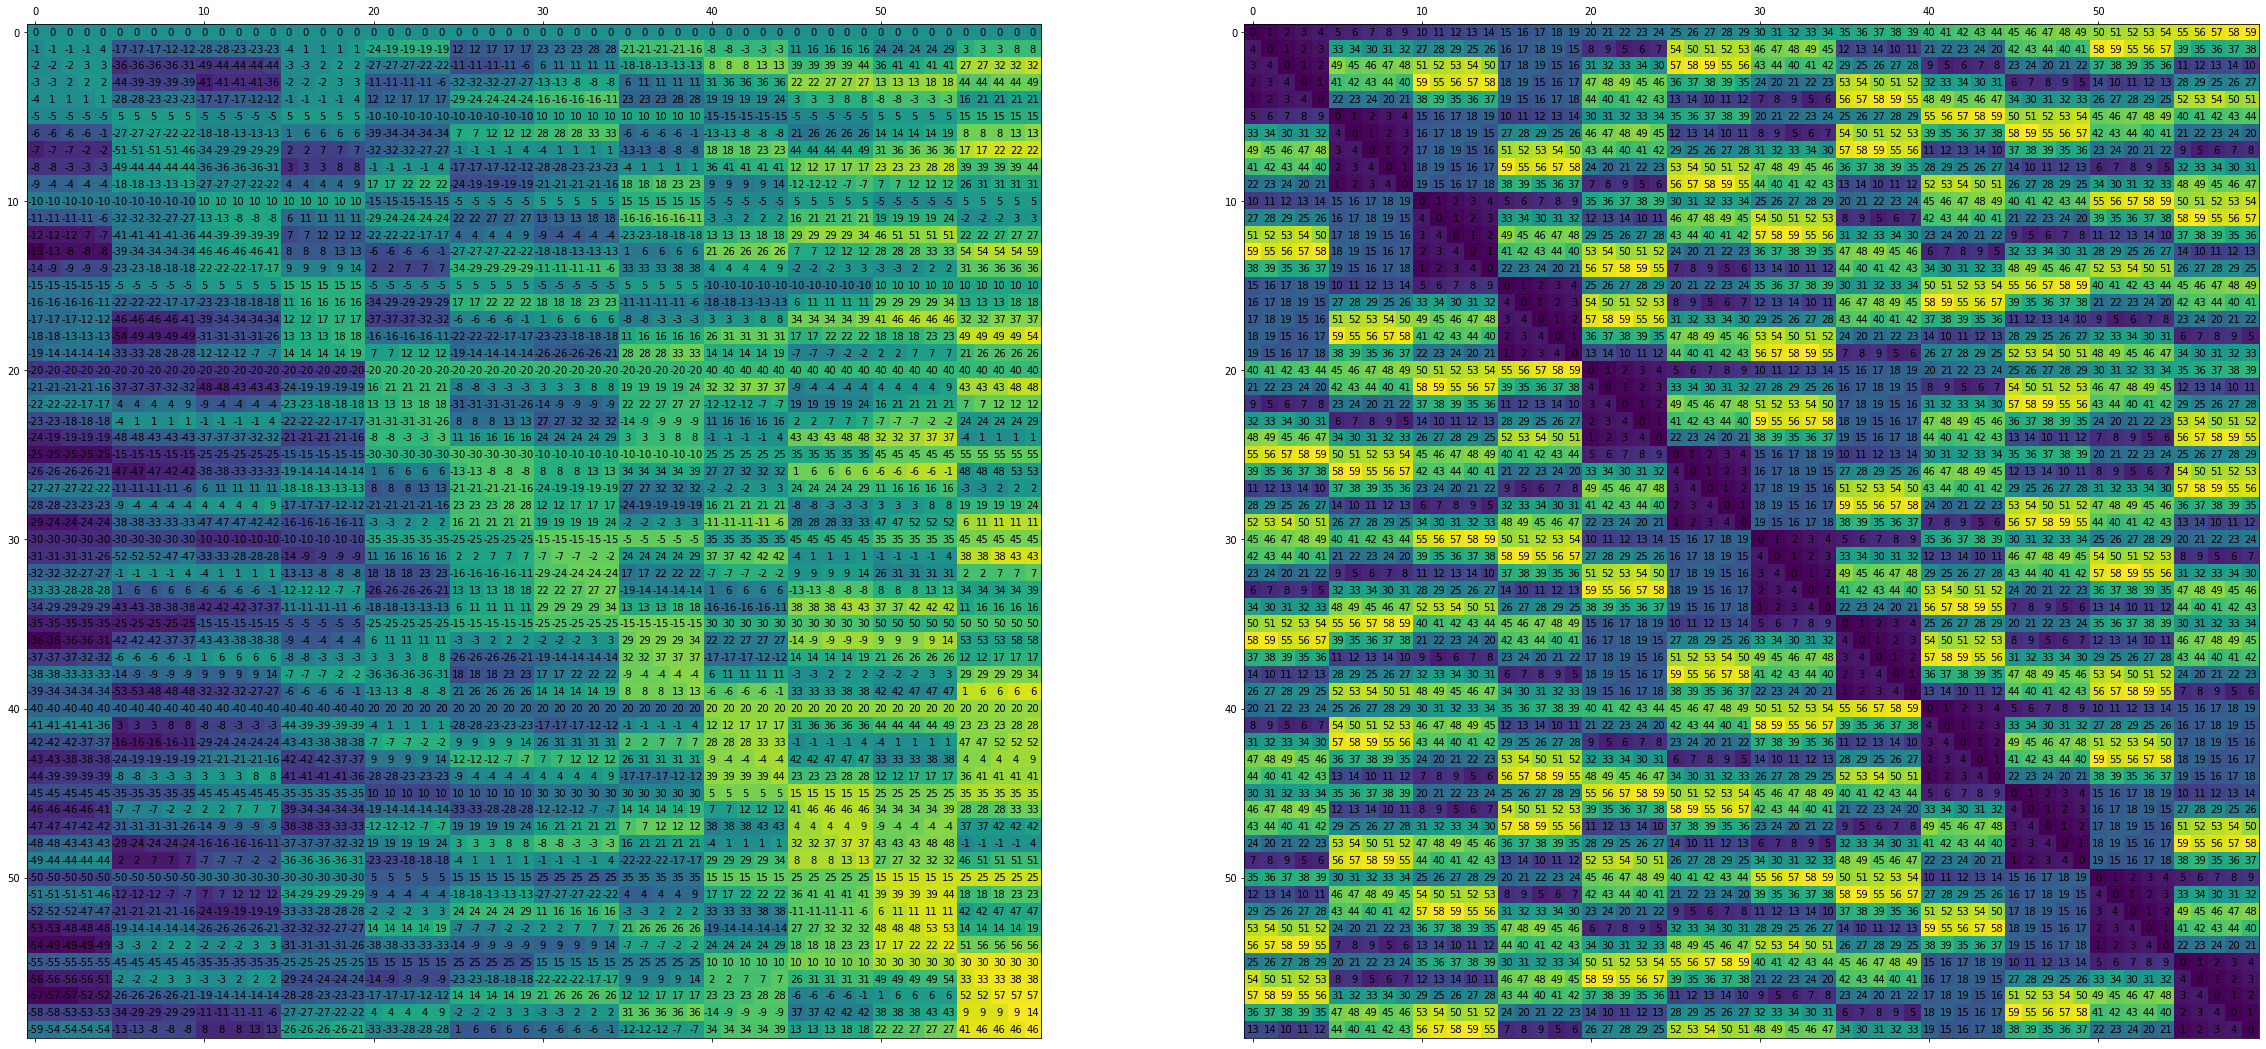

In [226]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].matshow(gS, vmin=-59, vmax=59)
#plt.gcf().set_aspect('auto')
plt.gcf().set_size_inches((40,20))
for i in range(60):
    for j in range(60):
        c = gSL[j,i]
        ax[0].text(i, j, str(c), va='center', ha='center')

ax[1].matshow(gL, vmin=0, vmax=59)
for i in range(60):
    for j in range(60):
        c = gL[j,i]
        ax[1].text(i, j, str(c), va='center', ha='center')

In [6]:
print('building full')
start = time.time()
hRow, hData, hCol = buildHessFull(hbrow,hbcol,hbdata, T, gSL, n_atoms, hDiags)
hFull = bsr_matrix((hData,hCol, hRow), blocksize=(3,3), shape=(3*n_atoms,3*n_atoms))
end = time.time()
print('done', end-start)
print(hData.shape) 

building full
done 0.735992431640625
(186540, 3, 3)


In [228]:
print(hCol.shape)

(186540,)


In [229]:
print(hFull.shape)
print(np.mean(np.abs(hData[hbdata.shape[0]:,:,:])))
print(np.mean(np.abs(hbdata)))
print(np.mean(np.abs(hFull.data[hbdata.shape[0]:,:,:])))

(26460, 26460)
0.37518369459274453
0.37596108995904126
0.37518369459274453


In [230]:
print(max(hCol))
print(3*n_atoms)

8819
26460


In [44]:
hFull = bsr_matrix((hData,hCol, hRow), blocksize=(3,3), size=(2))
print(hFull.shape)

(26460, 26442)


In [9]:
anm = ANM(pdb + '_full')
anm.buildHessian(calphas, cutoff=10, kdtree=True, sparse=True)
hPrody = anm.getHessian()

@> Using KDTree for building the Hessian.
@> Hessian was built in 24.19s.


In [240]:
print(np.allclose(hpD, hfD))

MemoryError: Unable to allocate 5.22 GiB for an array with shape (26460, 26460) and data type float64

In [237]:
print(np.max(hpD - hfD))

1.0018610682172024e-06


In [231]:
hpD = hPrody.todense()
hfD = hFull.todense()

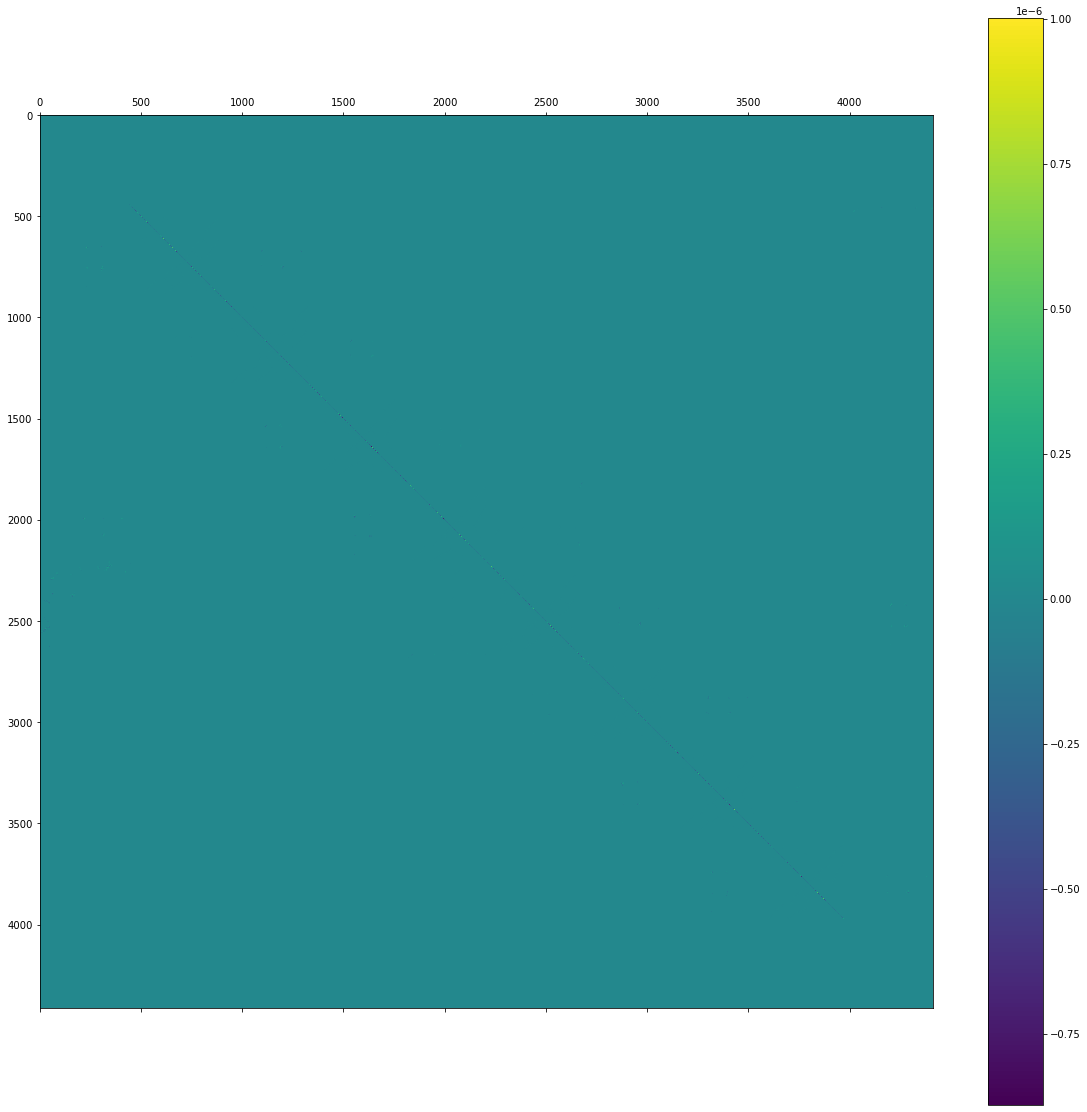

In [238]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
nslice = 10*3*147
a = ax.matshow(hpD[:nslice,:nslice] - hfD[:nslice,:nslice])
fig.colorbar(a)

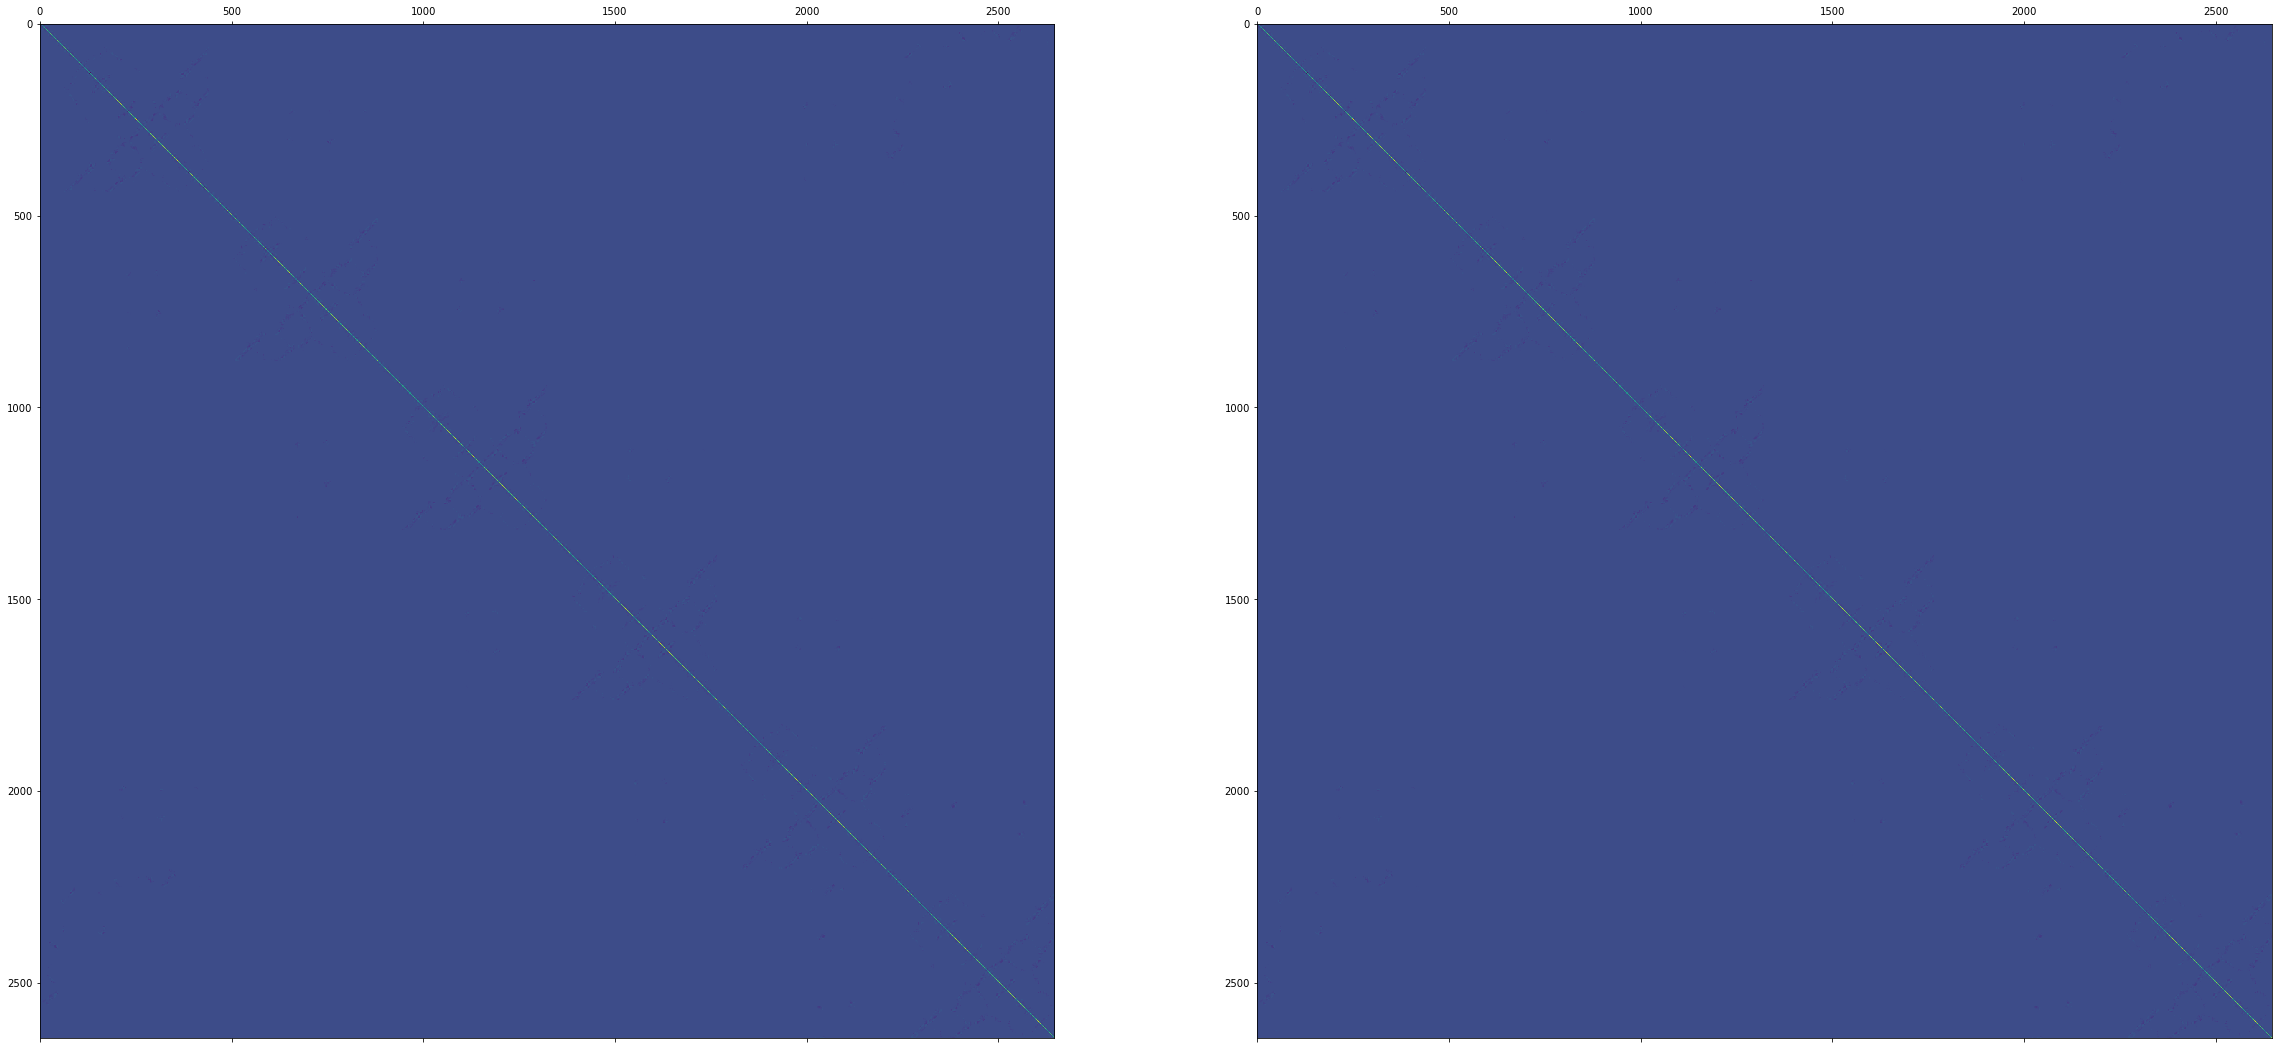

In [233]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40,20))
nslice = 6*3*147
nb =   0#3*147
a = ax[0].matshow(hfD[nb:nslice,nb:nslice])
#fig.colorbar(a)
b = ax[1].matshow(hpD[nb:nslice,nb:nslice])

In [242]:
nshow = 300*3
print(hpD[nshow:nshow+3,nshow:nshow+3])
print(hfD[nshow:nshow+3,nshow:nshow+3])

[[ 8.37279139 -2.419594    1.91128887]
 [-2.419594    7.93118793 -0.31375665]
 [ 1.91128887 -0.31375665  7.69602068]]
[[ 8.37279174 -2.41959414  1.91128895]
 [-2.41959414  7.93118794 -0.31375673]
 [ 1.91128895 -0.31375673  7.69602067]]


In [ ]:
nshow = 100*3
print(hpD[nshow:nshow+3,nshow:nshow+3])
print(hfD[nshow:nshow+3,nshow:nshow+3])